# Smartwatch based Stress Level Classification

### Student ID: 23346795
### MSc in Data Analytics (MSCDAD JAN25A I)

# 1. Introduction and Dataset Overview

# Dataset Info
Dataset: Smartwatch Health Data (Uncleaned)
Source: https://www.kaggle.com/datasets/mohammedarfathr/smartwatch-health-data-uncleaned/data

Problem: Classification (Predicting stress level based on physiological parameters)

Target Variable: Stress_Level

Features: BPM, SpO2, Stepcount,Sleep duration, Activity Level, Stress_Level (categorical)


In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from scipy import stats
import warnings

In [5]:
# Suppress warnings
warnings.filterwarnings('ignore')

In [6]:
# Set display options
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')


# 2. Data Loading and Initial Exploration


In [8]:
print("Loading the Smartwatch Health dataset...")

# Load the dataset
# If you're running this locally, adjust the path accordingly
df = pd.read_csv('smartwatch_health_data.csv')
print("Dataset loaded successfully.")
print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")

Loading the Smartwatch Health dataset...
Dataset loaded successfully.
Dataset loaded successfully with 10000 rows and 7 columns


In [9]:
# Display basic information about the dataset
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User ID                 9799 non-null   float64
 1   Heart Rate (BPM)        9600 non-null   float64
 2   Blood Oxygen Level (%)  9700 non-null   float64
 3   Step Count              9900 non-null   float64
 4   Sleep Duration (hours)  9850 non-null   object 
 5   Activity Level          9800 non-null   object 
 6   Stress Level            9800 non-null   object 
dtypes: float64(4), object(3)
memory usage: 547.0+ KB


In [10]:
print("\nFirst 5 rows of the dataset:")
df.head()


First 5 rows of the dataset:


,User ID,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,Stress Level
0,4174.0,58.939776,98.809650,5450.390578,7.167235622,Highly Active,1
1,NaN,NaN,98.532195,727.601610,6.538239376,Highly_Active,5
2,1860.0,247.803052,97.052954,2826.521994,ERROR,Highly Active,5
3,2294.0,40.000000,96.894213,13797.338040,7.36778963,Actve,3
4,2130.0,61.950165,98.583797,15679.067650,NaN,Highly_Active,6


In [11]:
print("\nSummary statistics:")
df.describe().round(2)


Summary statistics:


,User ID,Heart Rate (BPM),Blood Oxygen Level (%),Step Count
count,9799.00,9600.00,9700.00,9900.00
mean,3007.48,76.04,97.84,6985.69
std,1150.58,19.41,1.73,6885.81
min,1001.00,40.00,90.79,0.91
25%,1997.50,64.89,96.66,2021.04
50%,2998.00,75.22,98.01,4962.53
75%,4004.00,85.20,99.38,9724.90
max,4999.00,296.59,100.00,62486.69


In [12]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage.round(2)
})
print("\nMissing Values Analysis:")
print(missing_df[missing_df['Missing Values'] > 0])


Missing Values Analysis:
                        Missing Values  Percentage
User ID                            201        2.01
Heart Rate (BPM)                   400        4.00
Blood Oxygen Level (%)             300        3.00
Step Count                         100        1.00
Sleep Duration (hours)             150        1.50
Activity Level                     200        2.00
Stress Level                       200        2.00



# 3. Data Preprocessing and Cleaning


In [14]:
# rename stress level to stress_level
df.rename(columns={'Stress Level': 'stress_level'}, inplace=True)

In [15]:
# replace ERROR in Sleep Duration with np.nan
df.loc[df['Sleep Duration (hours)'] == 'ERROR', 'Sleep Duration (hours)'] = np.nan

In [16]:
# very high stress level to 20
df.loc[df['stress_level'] =='Very High', 'stress_level'] = 20

In [17]:
df.head()

,User ID,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,stress_level
0,4174.0,58.939776,98.809650,5450.390578,7.167235622,Highly Active,1
1,NaN,NaN,98.532195,727.601610,6.538239376,Highly_Active,5
2,1860.0,247.803052,97.052954,2826.521994,NaN,Highly Active,5
3,2294.0,40.000000,96.894213,13797.338040,7.36778963,Actve,3
4,2130.0,61.950165,98.583797,15679.067650,NaN,Highly_Active,6


In [18]:
def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the smartwatch dataset.
    Steps
    -----
    1. Drop duplicated rows.
    2. Remove obviously impossible sensor values (negative steps, SpO2,BPM etc.).
    3. Convert datatypes.
    4. Replace missing values with NaN so the Imputer can handle them.
    """
    df = df.copy()
    # 1. duplicates
    before = df.shape[0]
    df.drop_duplicates(inplace=True)
    print(f"[clean] Dropped {before-df.shape[0]} duplicate rows.")
    # 2. sensor sanity rules (domain knowledge)
    rules = {
        "steps"          : (lambda x: x>=0),
        "SpO2"           :(lambda x: (35 <= x) & (x<=42)),
        "bpm"            : (lambda x: (40 <= x) & (x<=220)),
    }
    for col, rule in rules.items():
        if col in df.columns:
            invalid = ~rule(df[col])
            df.loc[invalid, col] = np.nan       # set impossible values to NaN
    # 3. dtype conversion
    time_cols = [c for c in df.columns if "date" in c.lower() or "time" in c.lower()]
    for c in time_cols:
        df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

df_cleaned = preprocess_dataframe(df)
print(df_cleaned.isna().mean().sort_values(ascending=False).head(10))

[clean] Dropped 0 duplicate rows.
Heart Rate (BPM)          0.0400
Sleep Duration (hours)    0.0397
Blood Oxygen Level (%)    0.0300
User ID                   0.0201
Activity Level            0.0200
stress_level              0.0200
Step Count                0.0100
dtype: float64


In [19]:
print(df_cleaned.isna().sum().sort_values(ascending=False).head())

Heart Rate (BPM)          400
Sleep Duration (hours)    397
Blood Oxygen Level (%)    300
User ID                   201
Activity Level            200
dtype: int64


In [20]:
# change Sleep Duration (hours)	and stress_level as float column type
df_cleaned['Sleep Duration (hours)'] = df_cleaned['Sleep Duration (hours)'].astype(float)
df_cleaned['stress_level'] = df_cleaned['stress_level'].astype(float)

In [21]:
# Choose a strategy: mean, median, most_frequent, or constant
imputer = SimpleImputer(strategy="mean")  # use "median" for robustness

# Apply imputer to only numerical columns
numeric_cols = df_cleaned.select_dtypes(include='number').columns
df_cleaned[numeric_cols] = imputer.fit_transform(df_cleaned[numeric_cols])


In [22]:
print(df_cleaned.isna().sum().sort_values(ascending=False).head())

Activity Level            200
User ID                     0
Heart Rate (BPM)            0
Blood Oxygen Level (%)      0
Step Count                  0
dtype: int64


In [23]:
# fill nan of Activity Level with mode
df_cleaned['Activity Level'].fillna(df_cleaned['Activity Level'].mode()[0], inplace=True)

In [24]:
print(df_cleaned.isna().sum().sort_values(ascending=False).head())

User ID                   0
Heart Rate (BPM)          0
Blood Oxygen Level (%)    0
Step Count                0
Sleep Duration (hours)    0
dtype: int64


In [25]:
# ----- Feature / target split
TARGET = "stress_level"
X = df_cleaned.drop(columns=[TARGET])
y = df_cleaned[TARGET]

# ----- Numerical / categorical split (auto‑detect)
num_feats = X.select_dtypes(include=["number"]).columns.tolist()
cat_feats = X.select_dtypes(exclude=["number","datetime"]).columns.tolist()

print("Numerical:", num_feats)
print("Categorical:", cat_feats)

Numerical: ['User ID', 'Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count', 'Sleep Duration (hours)']
Categorical: ['Activity Level']


In [26]:
# ----- Train / test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=21, stratify=y)

# 4.  Exploratory Data Ananlysis (EDA)

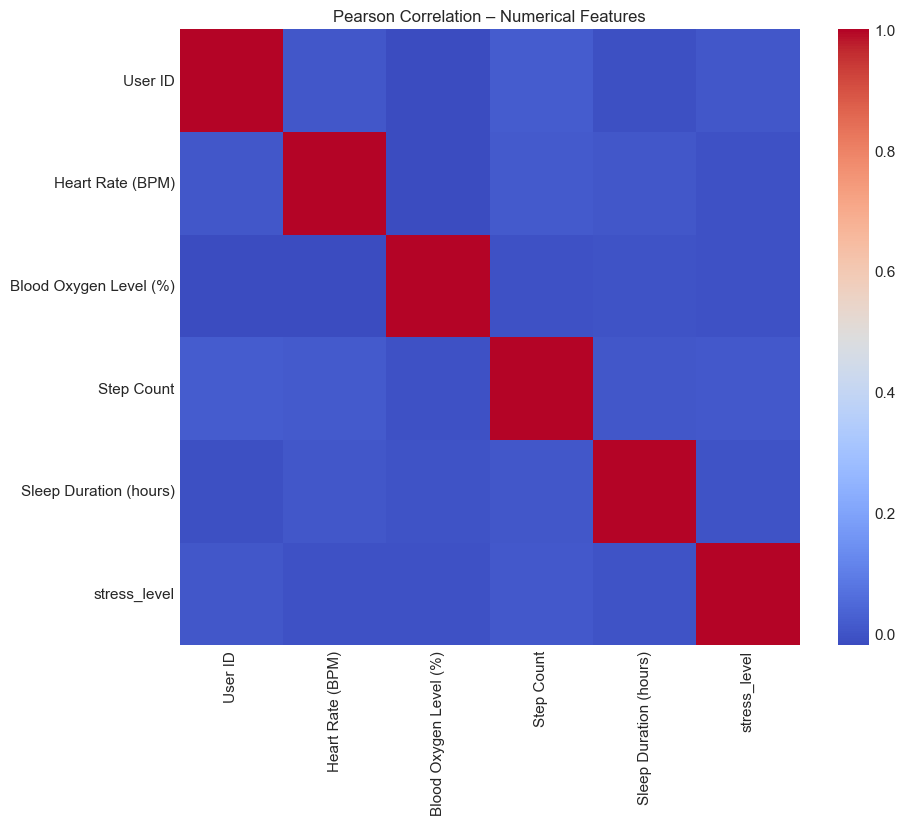

In [28]:
# Correlation heat‑map for numeric features
plt.figure(figsize=(10,8))
sns.heatmap(df_cleaned[num_feats+[TARGET]].corr(), cmap="coolwarm", annot=False)
plt.title("Pearson Correlation – Numerical Features")
plt.show()

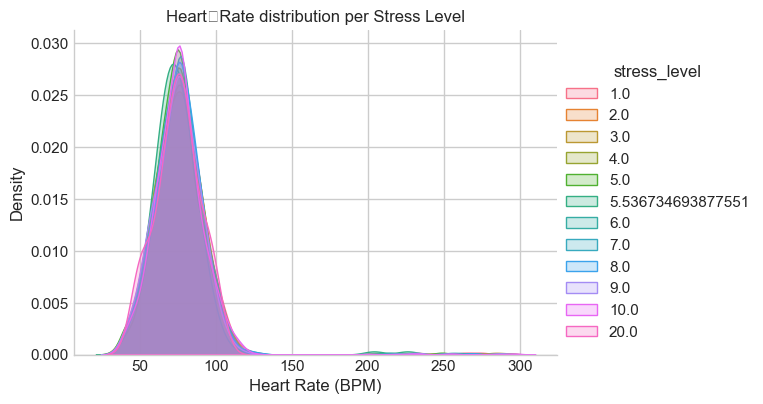

In [29]:
# KDE plots of heart‑rate & Blood Oxygen level grouped by stress level
g = sns.FacetGrid(df_cleaned, hue=TARGET, height=4, aspect=1.5)
g.map(sns.kdeplot, "Heart Rate (BPM)", fill=True, common_norm=False)
g.add_legend(); plt.title("Heart‑Rate distribution per Stress Level"); plt.show()


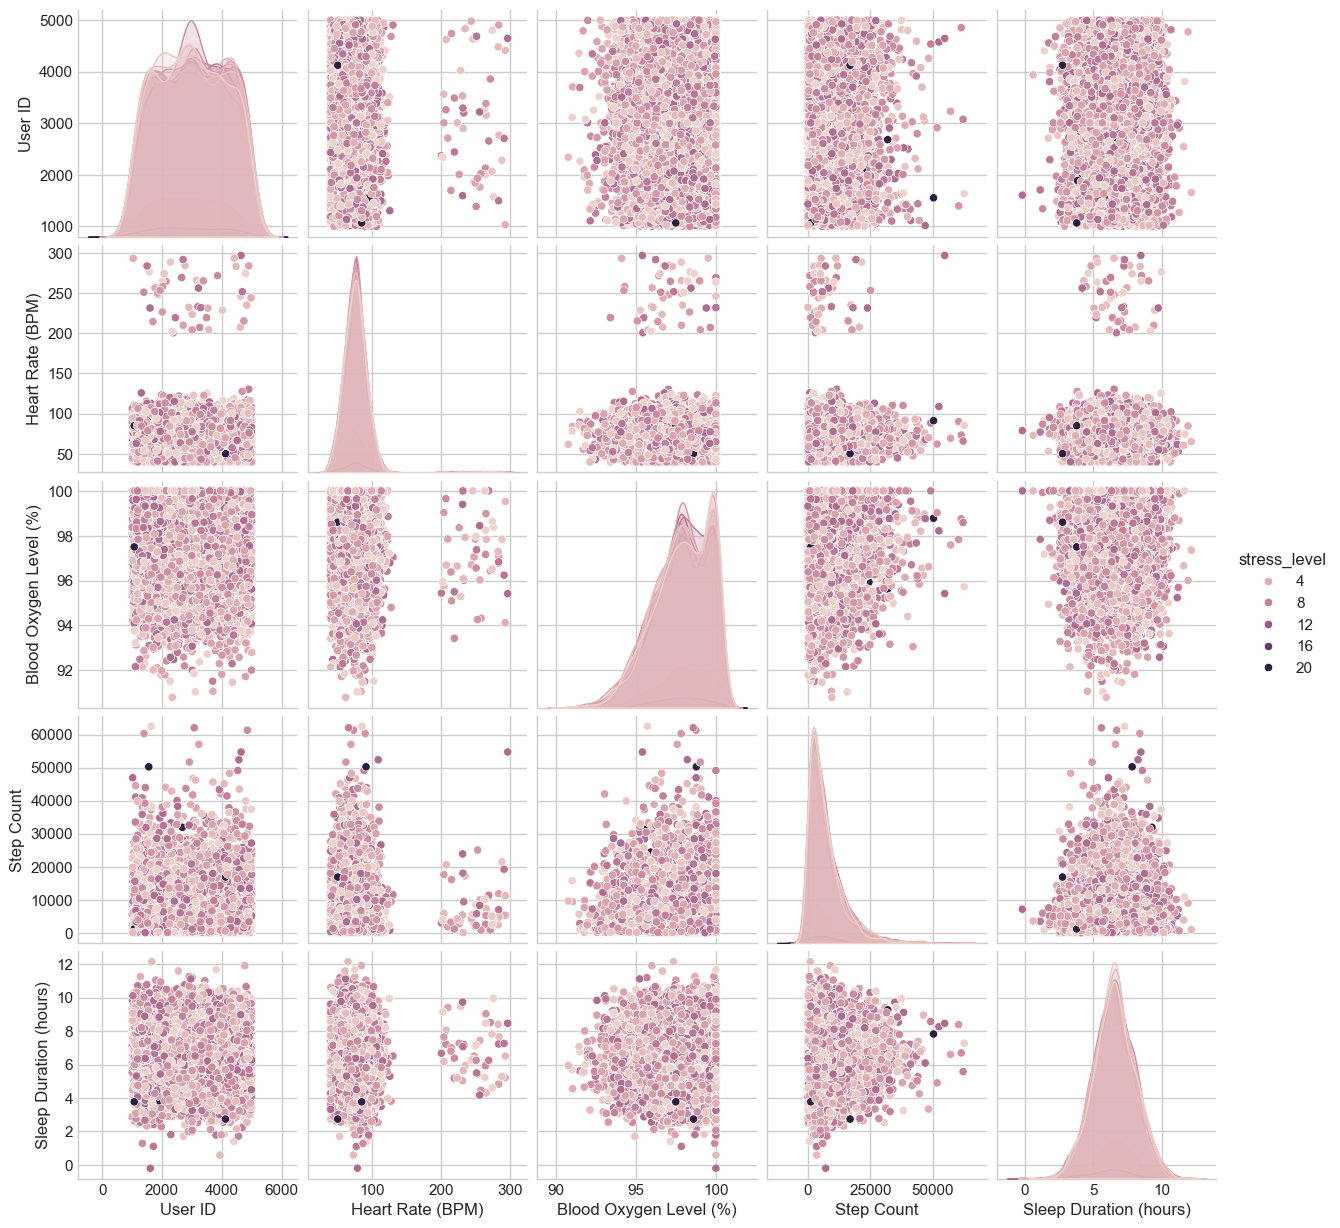

In [30]:
# Pairplot to visualize relationships between multiple numerical features
sns.pairplot(df_cleaned[num_feats + [TARGET]], hue=TARGET)
plt.show()

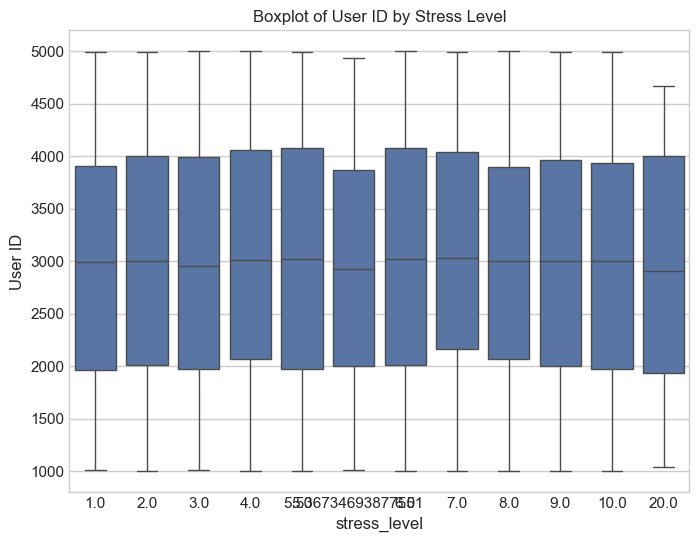

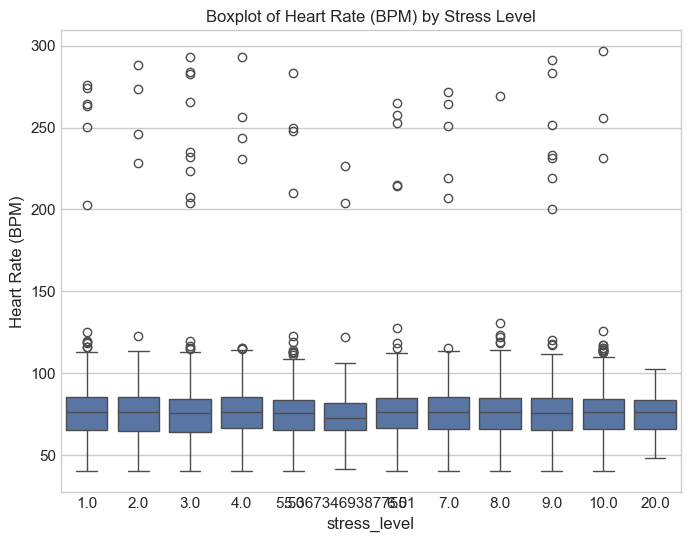

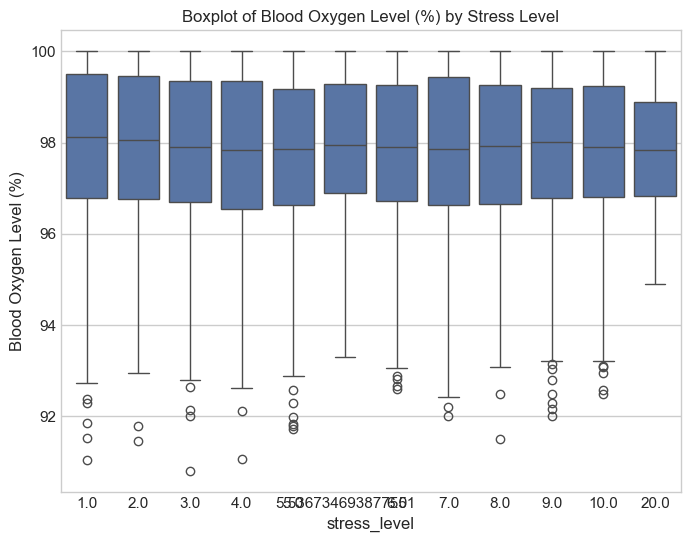

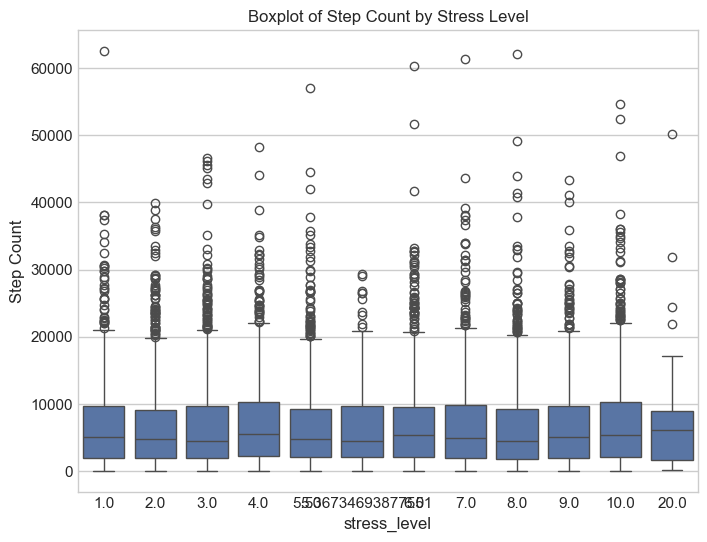

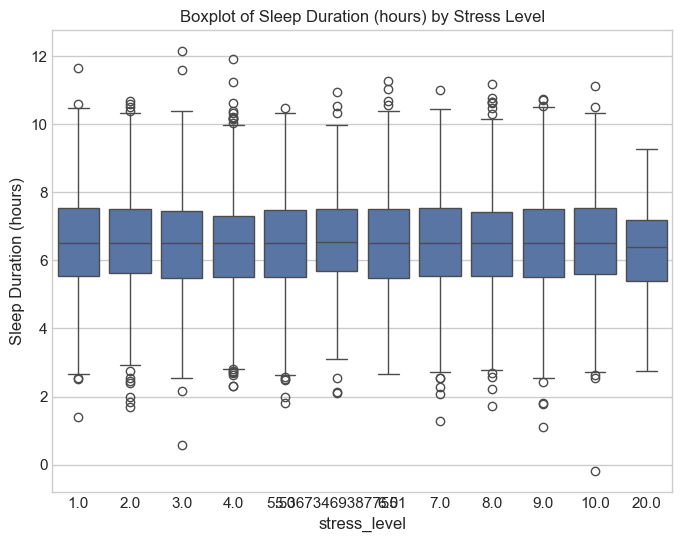

In [31]:
# Boxplots for numerical features grouped by stress level
for col in num_feats:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=TARGET, y=col, data=df_cleaned)
    plt.title(f"Boxplot of {col} by Stress Level")
    plt.show()

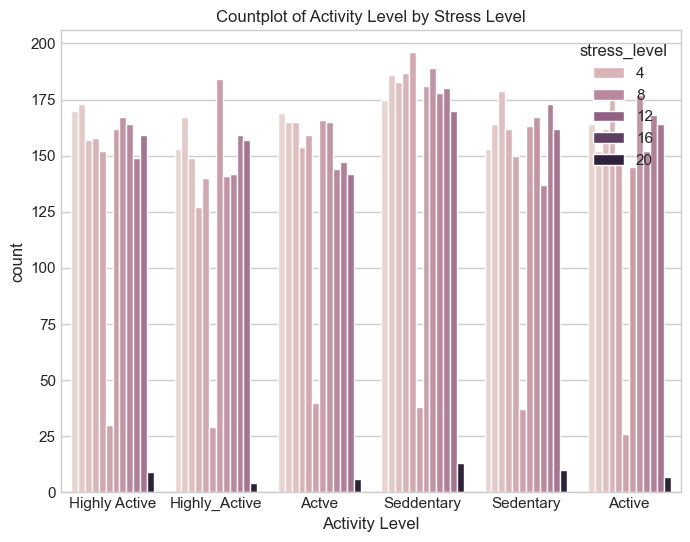

In [32]:
# Countplot for categorical features
for col in cat_feats:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, hue=TARGET, data=df_cleaned)
    plt.title(f"Countplot of {col} by Stress Level")
    plt.show()

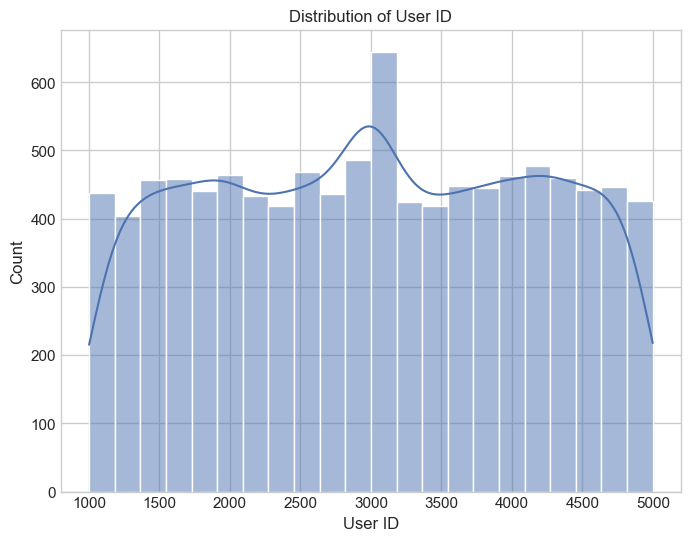

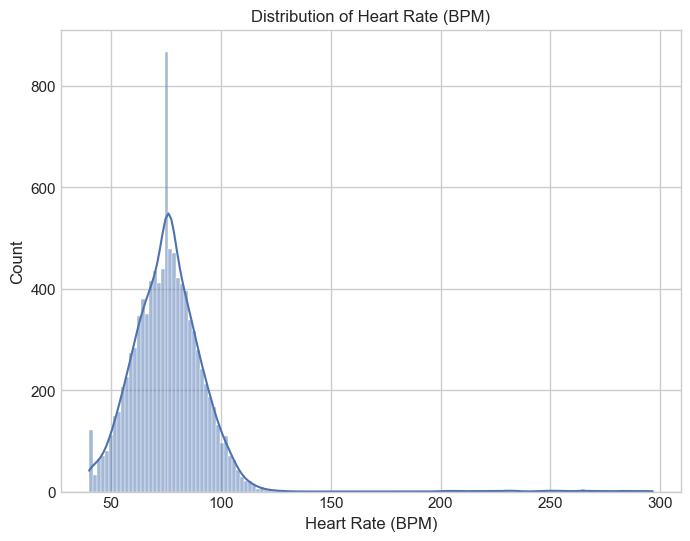

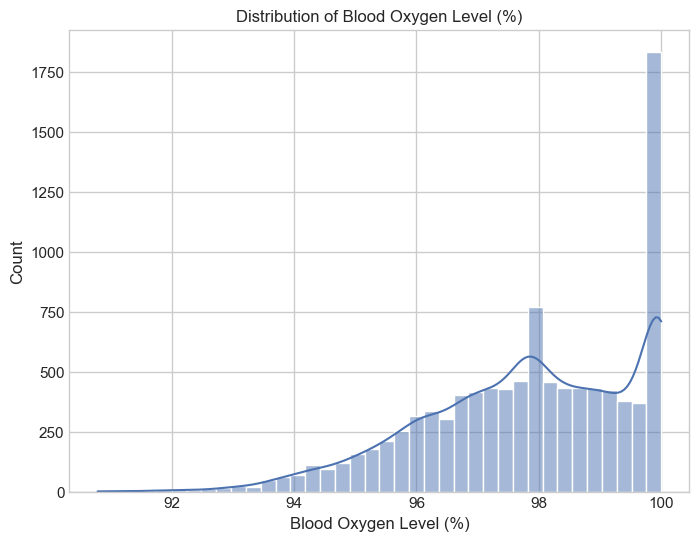

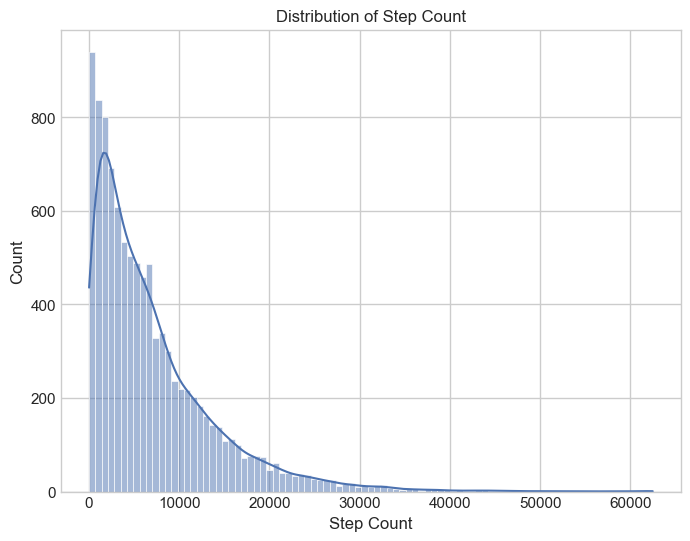

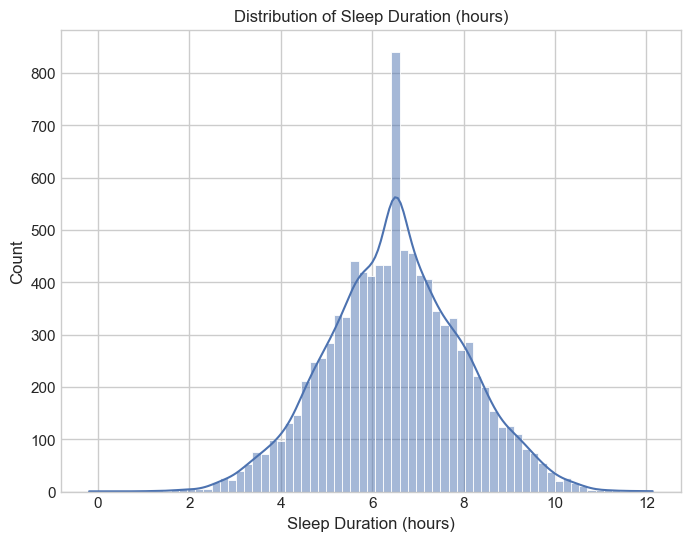

In [33]:
# Distribution plots for numerical features
for col in num_feats:
  plt.figure(figsize=(8, 6))
  sns.histplot(df_cleaned[col], kde=True)
  plt.title(f"Distribution of {col}")
  plt.show()

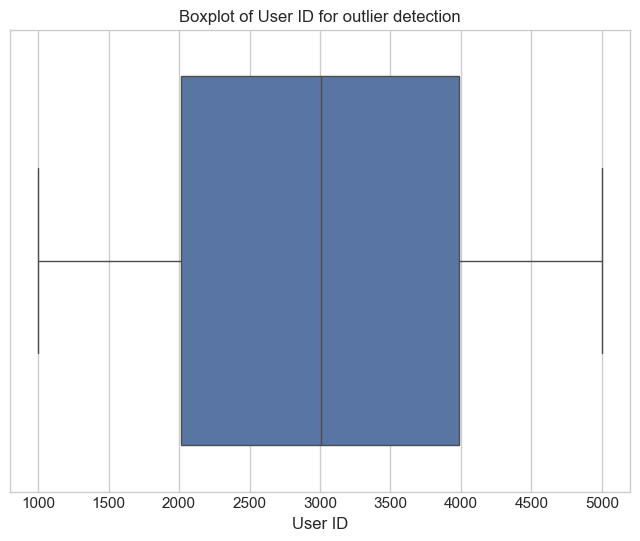

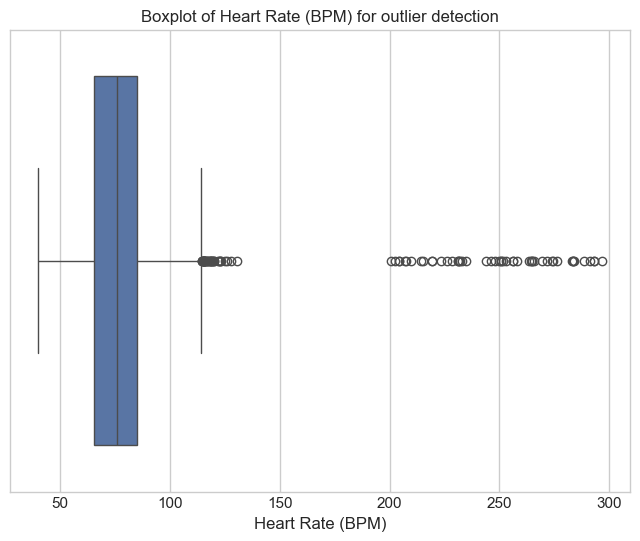

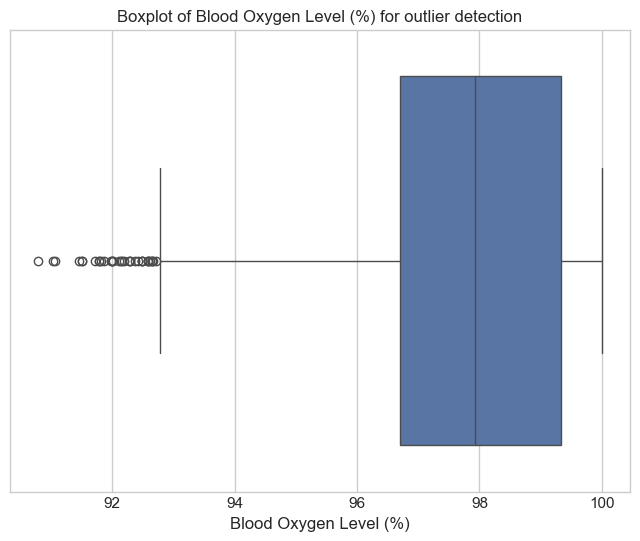

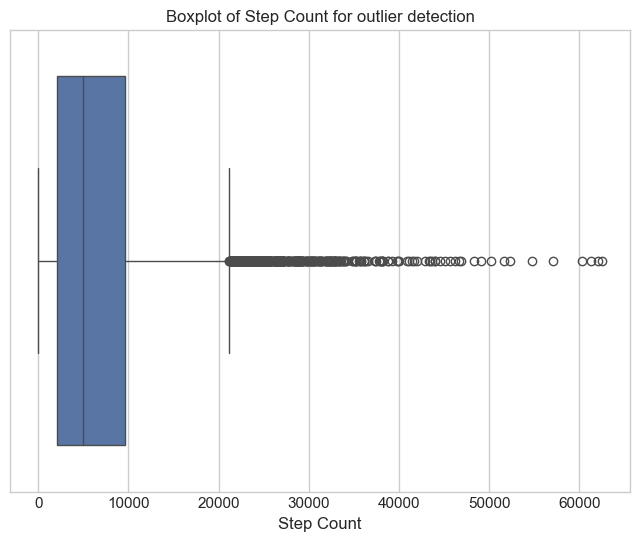

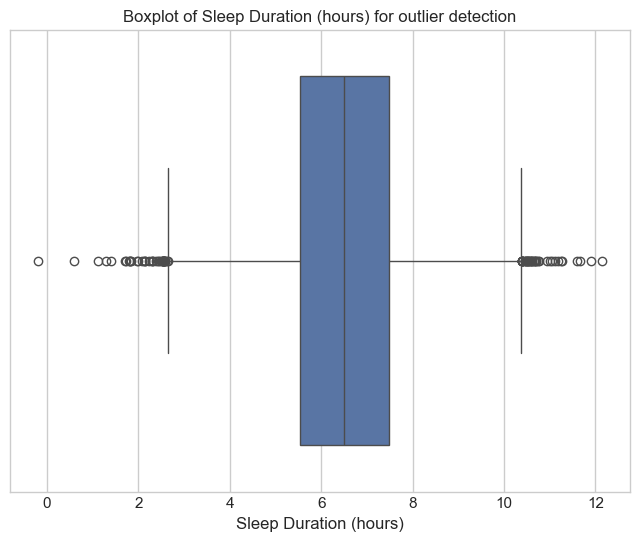

In [34]:
# Check for outliers using boxplots
for col in num_feats:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=col, data=df_cleaned)
    plt.title(f"Boxplot of {col} for outlier detection")
    plt.show()

In [35]:
# Descriptive statistics grouped by stress level
print(df_cleaned.groupby(TARGET).describe().transpose())

stress_level                     1.000000      2.000000      3.000000   \
User ID                count    984.000000   1007.000000    995.000000   
                       mean    2964.797283   3015.413311   2962.080970   
                       std     1137.576420   1145.240135   1134.061725   
                       min     1011.000000   1001.000000   1009.000000   
                       25%     1963.000000   2015.000000   1979.500000   
                       50%     2996.000000   3003.000000   2960.000000   
                       75%     3903.500000   3999.000000   3991.500000   
                       max     4991.000000   4996.000000   4999.000000   
Heart Rate (BPM)       count    984.000000   1007.000000    995.000000   
                       mean      76.550565     75.893698     75.906726   
                       std       20.549094     18.703818     21.888860   
                       min       40.000000     40.000000     40.000000   
                       25%       65.08

# 5.  Model Selection & Training

In [37]:
numeric_transformer   = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler" , StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot" , OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_feats),
    ("cat", categorical_transformer, cat_feats)
])

In [38]:
# group stress_level into 3 groups
# Low Stress	--> 1, 2, 3
# Moderate Stress	--> 4, 5, 6, 7
# High Stress	--> 8, 9, 10, 20
y_train_new = y_train.apply(lambda x: 'Low Stress' if x in [1, 2, 3] else ('Moderate Stress' if x in [4, 5, 6, 7] else 'High Stress'))
y_test_new = y_test.apply(lambda x: 'Low Stress' if x in [1, 2, 3] else ('Moderate Stress' if x in [4, 5, 6, 7] else 'High Stress'))

In [39]:
y_train_new.value_counts()

stress_level
Moderate Stress    3135
High Stress        2477
Low Stress         2388
Name: count, dtype: int64

In [40]:
# ---------------- Model A – Gradient Boosting ----------------------------------
gb_clf = GradientBoostingClassifier(random_state=21)
gb_param_grid = {
    "clf__n_estimators"    : [150, 200],
    "clf__learning_rate"   : [0.05, 0.1],
    "clf__max_depth"       : [3, 5]
}

gb_pipe = ImbPipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=21, k_neighbors=3)),
    ("clf", gb_clf)
])

gb_grid = GridSearchCV(
    gb_pipe,
    param_grid=gb_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=21),
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)
gb_grid.fit(X_train, y_train_new)
print("✓ GB best params:", gb_grid.best_params_)
print("✓ GB CV accuracy:", gb_grid.best_score_.round(4))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
✓ GB best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 150}
✓ GB CV accuracy: 0.3391


In [41]:
# ---------------- Model B – LightGBM ------------------------------------------
lgb_clf = LGBMClassifier(random_state=21)
lgb_param_grid = {
    "clf__n_estimators"    : [300, 500],
    "clf__num_leaves"      : [31, 63],
    "clf__learning_rate"   : [0.05, 0.1],
    "clf__max_depth"       : [-1, 7]
}

lgb_pipe = ImbPipeline([
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=21)),
    ("clf", lgb_clf)
])

lgb_grid = GridSearchCV(
    lgb_pipe,
    param_grid=lgb_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=21),
    scoring="accuracy",
    n_jobs=-1, verbose=1
)
lgb_grid.fit(X_train, y_train_new)
print("✓ LGB best params:", lgb_grid.best_params_)
print("✓ LGB CV accuracy:", lgb_grid.best_score_.round(4))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 9405, number of used features: 11
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
✓ LGB best params: {'clf__learning_rate': 0.1, 'clf__max_depth': -1, 'clf__n_estimators': 300, 'clf__num_leaves': 63}
✓ LGB CV accuracy: 0.3444


In [42]:
# ---------------- Model C : STACKING for marginal gains -----------------------
stack = StackingClassifier(
    estimators=[("gb", gb_grid.best_estimator_),
                ("lgb", lgb_grid.best_estimator_)],
    final_estimator=LGBMClassifier(random_state=21)
).fit(X_train, y_train_new)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 9405, number of used features: 11
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 7524, number of used features: 11
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing row-

In [43]:
# ---------------- Model D : Logistic Regression -----------------------
lr_clf = LogisticRegression(random_state=21)
lr_param_grid = {
    "clf__C" : [0.001, 0.01, 0.1, 1, 10, 100]
}

lr_pipe = ImbPipeline([
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=21)),
    ("clf", lr_clf)
])

lr_grid = GridSearchCV(
    lr_pipe,
    param_grid=lr_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=21),
    scoring="accuracy",
    n_jobs=-1, verbose=1
)
lr_grid.fit(X_train, y_train_new)
print("✓ LR best params:", lr_grid.best_params_)
print("✓ LR CV accuracy:", lr_grid.best_score_.round(4))
print("✓ LR test accuracy:", lr_grid.score(X_test, y_test_new))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
✓ LR best params: {'clf__C': 0.001}
✓ LR CV accuracy: 0.342
✓ LR test accuracy: 0.332


# 6. Performance Evaluation

In [45]:
def evaluate(model, X_tr, y_tr, X_te, y_te, label:str):
    y_pred  = model.predict(X_te)
    y_prob  = model.predict_proba(X_te)
    acc     = accuracy_score(y_te, y_pred)
    print(f"\n—— {label} ——")
    print("Accuracy :", acc)
    print(classification_report(y_te, y_pred))
    cm = confusion_matrix(y_te, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{label} – Confusion Matrix"); plt.show()
    # ROC‑AUC (One‑vs‑Rest micro)
    auc = roc_auc_score(y_te, y_prob, multi_class="ovr", average="macro")
    print("Macro‑AUC:", auc.round(4))
    return acc, auc


—— GradientBoosting ——
Accuracy : 0.3305
                 precision    recall  f1-score   support

    High Stress       0.32      0.36      0.34       619
     Low Stress       0.30      0.32      0.31       598
Moderate Stress       0.38      0.31      0.34       783

       accuracy                           0.33      2000
      macro avg       0.33      0.33      0.33      2000
   weighted avg       0.34      0.33      0.33      2000



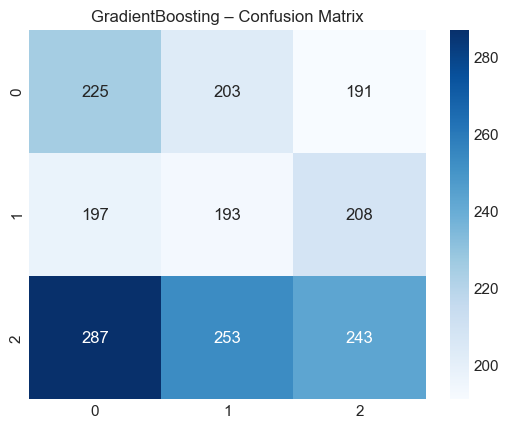

Macro‑AUC: 0.4958

—— LightGBM ——
Accuracy : 0.342
                 precision    recall  f1-score   support

    High Stress       0.31      0.31      0.31       619
     Low Stress       0.31      0.33      0.32       598
Moderate Stress       0.39      0.37      0.38       783

       accuracy                           0.34      2000
      macro avg       0.34      0.34      0.34      2000
   weighted avg       0.34      0.34      0.34      2000



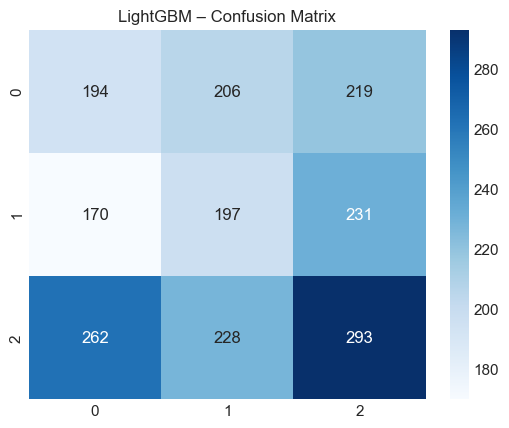

Macro‑AUC: 0.5062

—— Stacking ——
Accuracy : 0.365
                 precision    recall  f1-score   support

    High Stress       0.31      0.21      0.25       619
     Low Stress       0.30      0.17      0.22       598
Moderate Stress       0.40      0.64      0.49       783

       accuracy                           0.36      2000
      macro avg       0.34      0.34      0.32      2000
   weighted avg       0.34      0.36      0.33      2000



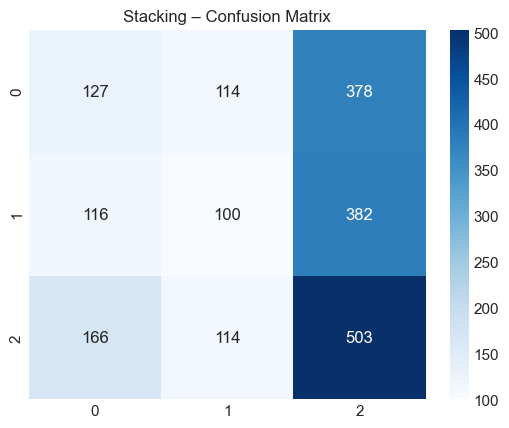

Macro‑AUC: 0.5013

—— LogisticRegression ——
Accuracy : 0.332
                 precision    recall  f1-score   support

    High Stress       0.29      0.23      0.26       619
     Low Stress       0.29      0.39      0.33       598
Moderate Stress       0.41      0.37      0.39       783

       accuracy                           0.33      2000
      macro avg       0.33      0.33      0.33      2000
   weighted avg       0.34      0.33      0.33      2000



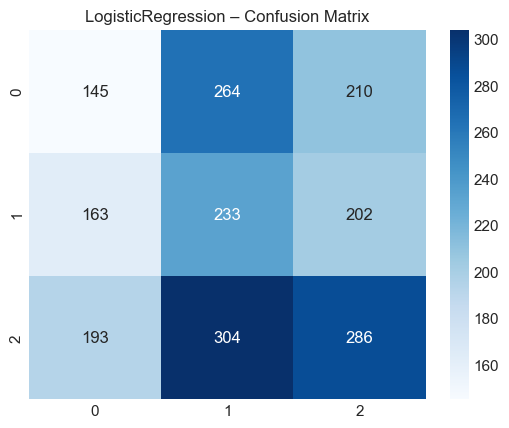

Macro‑AUC: 0.4931
GradientBoosting      0.3305
LightGBM              0.3420
Stacking              0.3650
LogisticRegression    0.3320
dtype: float64


In [46]:
results = {}
for m, lbl in zip([gb_grid.best_estimator_, lgb_grid.best_estimator_, stack, lr_grid.best_estimator_],
                  ["GradientBoosting", "LightGBM", "Stacking", 'LogisticRegression']):
    results[lbl] = evaluate(m, X_train, y_train_new, X_test, y_test_new, lbl)

print(pd.Series(results).apply(lambda x: x[0]))